In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [44]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [45]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Relying on 'stored_game_boxes' currently loaded into memory
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 3224500

[85/5670] Updated 5FR Margin for game_id 322522653.
[86/5670] Updating 5FR Margin for game_id 322522751...
[86/5670] Updated 5FR Margin for game_id 322522751.
[87/5670] Updating 5FR Margin for game_id 322570058...
[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game_id 322590002.
[90/5670] Updating 5FR Margin for game_id 322590008...
[90/5670] Updated 5FR Margin for game_id 322590008.
[91/5670] Updating 5FR Margin for game_id 322590023...
[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game

[168/5670] Updated 5FR Margin for game_id 322660356.
[169/5670] Updating 5FR Margin for game_id 322662050...
[169/5670] Updated 5FR Margin for game_id 322662050.
[170/5670] Updating 5FR Margin for game_id 322662229...
[170/5670] Updated 5FR Margin for game_id 322662229.
[171/5670] Updating 5FR Margin for game_id 322662294...
[171/5670] Updated 5FR Margin for game_id 322662294.
[172/5670] Updating 5FR Margin for game_id 322662439...
[172/5670] Updated 5FR Margin for game_id 322662439.
[173/5670] Updating 5FR Margin for game_id 322662459...
[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 5FR Margin for game_id 322662483.
[175/5670] Updating 5FR Margin for game_id 322662579...
[175/5670] Updated 5FR Margin for game_id 322662579.
[176/5670] Updating 5FR Margin for game_id 322662628...
[176/5670] Updated 5FR Margin for game_id 322662628.
[177/5670] Updating 5FR Margin for game_id 322662633...
[177/5670] Updated 

[247/5670] Updated 5FR Margin for game_id 322800164.
[248/5670] Updating 5FR Margin for game_id 322800167...
[248/5670] Updated 5FR Margin for game_id 322800167.
[249/5670] Updating 5FR Margin for game_id 322800194...
[249/5670] Updated 5FR Margin for game_id 322800194.
[250/5670] Updating 5FR Margin for game_id 322800195...
[250/5670] Updated 5FR Margin for game_id 322800195.
[251/5670] Updating 5FR Margin for game_id 322800204...
[251/5670] Updated 5FR Margin for game_id 322800204.
[252/5670] Updating 5FR Margin for game_id 322800213...
[252/5670] Updated 5FR Margin for game_id 322800213.
[253/5670] Updating 5FR Margin for game_id 322800218...
[253/5670] Updated 5FR Margin for game_id 322800218.
[254/5670] Updating 5FR Margin for game_id 322800228...
[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 

[324/5670] Updated 5FR Margin for game_id 322872390.
[325/5670] Updating 5FR Margin for game_id 322872433...
[325/5670] Updated 5FR Margin for game_id 322872433.
[326/5670] Updating 5FR Margin for game_id 322872439...
[326/5670] Updated 5FR Margin for game_id 322872439.
[327/5670] Updating 5FR Margin for game_id 322872459...
[327/5670] Updated 5FR Margin for game_id 322872459.
[328/5670] Updating 5FR Margin for game_id 322872509...
[328/5670] Updated 5FR Margin for game_id 322872509.
[329/5670] Updating 5FR Margin for game_id 322872641...
[329/5670] Updated 5FR Margin for game_id 322872641.
[330/5670] Updating 5FR Margin for game_id 322872751...
[330/5670] Updated 5FR Margin for game_id 322872751.
[331/5670] Updating 5FR Margin for game_id 322900249...
[331/5670] Updated 5FR Margin for game_id 322900249.
[332/5670] Updating 5FR Margin for game_id 322920009...
[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 

[409/5670] Updated 5FR Margin for game_id 323010158.
[410/5670] Updating 5FR Margin for game_id 323010164...
[410/5670] Updated 5FR Margin for game_id 323010164.
[411/5670] Updating 5FR Margin for game_id 323010166...
[411/5670] Updated 5FR Margin for game_id 323010166.
[412/5670] Updating 5FR Margin for game_id 323010167...
[412/5670] Updated 5FR Margin for game_id 323010167.
[413/5670] Updating 5FR Margin for game_id 323010189...
[413/5670] Updated 5FR Margin for game_id 323010189.
[414/5670] Updating 5FR Margin for game_id 323010193...
[414/5670] Updated 5FR Margin for game_id 323010193.
[415/5670] Updating 5FR Margin for game_id 323010197...
[415/5670] Updated 5FR Margin for game_id 323010197.
[416/5670] Updating 5FR Margin for game_id 323010201...
[416/5670] Updated 5FR Margin for game_id 323010201.
[417/5670] Updating 5FR Margin for game_id 323010213...
[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 

[489/5670] Updated 5FR Margin for game_id 323082426.
[490/5670] Updating 5FR Margin for game_id 323082433...
[490/5670] Updated 5FR Margin for game_id 323082433.
[491/5670] Updating 5FR Margin for game_id 323082439...
[491/5670] Updated 5FR Margin for game_id 323082439.
[492/5670] Updating 5FR Margin for game_id 323082459...
[492/5670] Updated 5FR Margin for game_id 323082459.
[493/5670] Updating 5FR Margin for game_id 323082509...
[493/5670] Updated 5FR Margin for game_id 323082509.
[494/5670] Updating 5FR Margin for game_id 323082572...
[494/5670] Updated 5FR Margin for game_id 323082572.
[495/5670] Updating 5FR Margin for game_id 323082633...
[495/5670] Updated 5FR Margin for game_id 323082633.
[496/5670] Updating 5FR Margin for game_id 323082641...
[496/5670] Updated 5FR Margin for game_id 323082641.
[497/5670] Updating 5FR Margin for game_id 323082655...
[497/5670] Updated 5FR Margin for game_id 323082655.
[498/5670] Updating 5FR Margin for game_id 323082751...
[498/5670] Updated 

[569/5670] Updated 5FR Margin for game_id 323220103.
[570/5670] Updating 5FR Margin for game_id 323220120...
[570/5670] Updated 5FR Margin for game_id 323220120.
[571/5670] Updating 5FR Margin for game_id 323220127...
[571/5670] Updated 5FR Margin for game_id 323220127.
[572/5670] Updating 5FR Margin for game_id 323220130...
[572/5670] Updated 5FR Margin for game_id 323220130.
[573/5670] Updating 5FR Margin for game_id 323220142...
[573/5670] Updated 5FR Margin for game_id 323220142.
[574/5670] Updating 5FR Margin for game_id 323220158...
[574/5670] Updated 5FR Margin for game_id 323220158.
[575/5670] Updating 5FR Margin for game_id 323220167...
[575/5670] Updated 5FR Margin for game_id 323220167.
[576/5670] Updating 5FR Margin for game_id 323220189...
[576/5670] Updated 5FR Margin for game_id 323220189.
[577/5670] Updating 5FR Margin for game_id 323220197...
[577/5670] Updated 5FR Margin for game_id 323220197.
[578/5670] Updating 5FR Margin for game_id 323220202...
[578/5670] Updated 

[648/5670] Updated 5FR Margin for game_id 323290259.
[649/5670] Updating 5FR Margin for game_id 323290278...
[649/5670] Updated 5FR Margin for game_id 323290278.
[650/5670] Updating 5FR Margin for game_id 323290309...
[650/5670] Updated 5FR Margin for game_id 323290309.
[651/5670] Updating 5FR Margin for game_id 323290333...
[651/5670] Updated 5FR Margin for game_id 323290333.
[652/5670] Updating 5FR Margin for game_id 323292116...
[652/5670] Updated 5FR Margin for game_id 323292116.
[653/5670] Updating 5FR Margin for game_id 323292229...
[653/5670] Updated 5FR Margin for game_id 323292229.
[654/5670] Updating 5FR Margin for game_id 323292393...
[654/5670] Updated 5FR Margin for game_id 323292393.
[655/5670] Updating 5FR Margin for game_id 323292509...
[655/5670] Updated 5FR Margin for game_id 323292509.
[656/5670] Updating 5FR Margin for game_id 323292567...
[656/5670] Updated 5FR Margin for game_id 323292567.
[657/5670] Updating 5FR Margin for game_id 323292633...
[657/5670] Updated 

[731/5670] Updated 5FR Margin for game_id 332500030.
[732/5670] Updating 5FR Margin for game_id 332500061...
[732/5670] Updated 5FR Margin for game_id 332500061.
[733/5670] Updating 5FR Margin for game_id 332500077...
[733/5670] Updated 5FR Margin for game_id 332500077.
[734/5670] Updating 5FR Margin for game_id 332500084...
[734/5670] Updated 5FR Margin for game_id 332500084.
[735/5670] Updating 5FR Margin for game_id 332500096...
[735/5670] Updated 5FR Margin for game_id 332500096.
[736/5670] Updating 5FR Margin for game_id 332500099...
[736/5670] Updated 5FR Margin for game_id 332500099.
[737/5670] Updating 5FR Margin for game_id 332500120...
[737/5670] Updated 5FR Margin for game_id 332500120.
[738/5670] Updating 5FR Margin for game_id 332500127...
[738/5670] Updated 5FR Margin for game_id 332500127.
[739/5670] Updating 5FR Margin for game_id 332500130...
[739/5670] Updated 5FR Margin for game_id 332500130.
[740/5670] Updating 5FR Margin for game_id 332500142...
[740/5670] Updated 

[808/5670] Updated 5FR Margin for game_id 332572509.
[809/5670] Updating 5FR Margin for game_id 332572579...
[809/5670] Updated 5FR Margin for game_id 332572579.
[810/5670] Updating 5FR Margin for game_id 332620152...
[810/5670] Updated 5FR Margin for game_id 332620152.
[811/5670] Updating 5FR Margin for game_id 332630278...
[811/5670] Updated 5FR Margin for game_id 332630278.
[812/5670] Updating 5FR Margin for game_id 332640021...
[812/5670] Updated 5FR Margin for game_id 332640021.
[813/5670] Updating 5FR Margin for game_id 332640024...
[813/5670] Updated 5FR Margin for game_id 332640024.
[814/5670] Updating 5FR Margin for game_id 332640026...
[814/5670] Updated 5FR Margin for game_id 332640026.
[815/5670] Updating 5FR Margin for game_id 332640030...
[815/5670] Updated 5FR Margin for game_id 332640030.
[816/5670] Updating 5FR Margin for game_id 332640041...
[816/5670] Updated 5FR Margin for game_id 332640041.
[817/5670] Updating 5FR Margin for game_id 332640057...
[817/5670] Updated 

[886/5670] Updated 5FR Margin for game_id 332710333.
[887/5670] Updating 5FR Margin for game_id 332710356...
[887/5670] Updated 5FR Margin for game_id 332710356.
[888/5670] Updating 5FR Margin for game_id 332712050...
[888/5670] Updated 5FR Margin for game_id 332712050.
[889/5670] Updating 5FR Margin for game_id 332712084...
[889/5670] Updated 5FR Margin for game_id 332712084.
[890/5670] Updating 5FR Margin for game_id 332712116...
[890/5670] Updated 5FR Margin for game_id 332712116.
[891/5670] Updating 5FR Margin for game_id 332712348...
[891/5670] Updated 5FR Margin for game_id 332712348.
[892/5670] Updating 5FR Margin for game_id 332712433...
[892/5670] Updated 5FR Margin for game_id 332712433.
[893/5670] Updating 5FR Margin for game_id 332712440...
[893/5670] Updated 5FR Margin for game_id 332712440.
[894/5670] Updating 5FR Margin for game_id 332712483...
[894/5670] Updated 5FR Margin for game_id 332712483.
[895/5670] Updating 5FR Margin for game_id 332712509...
[895/5670] Updated 

[965/5670] Updated 5FR Margin for game_id 332850096.
[966/5670] Updating 5FR Margin for game_id 332850099...
[966/5670] Updated 5FR Margin for game_id 332850099.
[967/5670] Updating 5FR Margin for game_id 332850113...
[967/5670] Updated 5FR Margin for game_id 332850113.
[968/5670] Updating 5FR Margin for game_id 332850120...
[968/5670] Updated 5FR Margin for game_id 332850120.
[969/5670] Updating 5FR Margin for game_id 332850127...
[969/5670] Updated 5FR Margin for game_id 332850127.
[970/5670] Updating 5FR Margin for game_id 332850145...
[970/5670] Updated 5FR Margin for game_id 332850145.
[971/5670] Updating 5FR Margin for game_id 332850150...
[971/5670] Updated 5FR Margin for game_id 332850150.
[972/5670] Updating 5FR Margin for game_id 332850152...
[972/5670] Updated 5FR Margin for game_id 332850152.
[973/5670] Updating 5FR Margin for game_id 332850195...
[973/5670] Updated 5FR Margin for game_id 332850195.
[974/5670] Updating 5FR Margin for game_id 332850213...
[974/5670] Updated 

[1042/5670] Updated 5FR Margin for game_id 332922117.
[1043/5670] Updating 5FR Margin for game_id 332922132...
[1043/5670] Updated 5FR Margin for game_id 332922132.
[1044/5670] Updating 5FR Margin for game_id 332922199...
[1044/5670] Updated 5FR Margin for game_id 332922199.
[1045/5670] Updating 5FR Margin for game_id 332922305...
[1045/5670] Updated 5FR Margin for game_id 332922305.
[1046/5670] Updating 5FR Margin for game_id 332922348...
[1046/5670] Updated 5FR Margin for game_id 332922348.
[1047/5670] Updating 5FR Margin for game_id 332922483...
[1047/5670] Updated 5FR Margin for game_id 332922483.
[1048/5670] Updating 5FR Margin for game_id 332922633...
[1048/5670] Updated 5FR Margin for game_id 332922633.
[1049/5670] Updating 5FR Margin for game_id 332922649...
[1049/5670] Updated 5FR Margin for game_id 332922649.
[1050/5670] Updating 5FR Margin for game_id 332922711...
[1050/5670] Updated 5FR Margin for game_id 332922711.
[1051/5670] Updating 5FR Margin for game_id 332922751...
[

[1121/5670] Updated 5FR Margin for game_id 333060087.
[1122/5670] Updating 5FR Margin for game_id 333060103...
[1122/5670] Updated 5FR Margin for game_id 333060103.
[1123/5670] Updating 5FR Margin for game_id 333060113...
[1123/5670] Updated 5FR Margin for game_id 333060113.
[1124/5670] Updating 5FR Margin for game_id 333060127...
[1124/5670] Updated 5FR Margin for game_id 333060127.
[1125/5670] Updating 5FR Margin for game_id 333060142...
[1125/5670] Updated 5FR Margin for game_id 333060142.
[1126/5670] Updating 5FR Margin for game_id 333060152...
[1126/5670] Updated 5FR Margin for game_id 333060152.
[1127/5670] Updating 5FR Margin for game_id 333060158...
[1127/5670] Updated 5FR Margin for game_id 333060158.
[1128/5670] Updating 5FR Margin for game_id 333060164...
[1128/5670] Updated 5FR Margin for game_id 333060164.
[1129/5670] Updating 5FR Margin for game_id 333060183...
[1129/5670] Updated 5FR Margin for game_id 333060183.
[1130/5670] Updating 5FR Margin for game_id 333060202...
[

[1200/5670] Updated 5FR Margin for game_id 333132636.
[1201/5670] Updating 5FR Margin for game_id 333132641...
[1201/5670] Updated 5FR Margin for game_id 333132641.
[1202/5670] Updating 5FR Margin for game_id 333132751...
[1202/5670] Updated 5FR Margin for game_id 333132751.
[1203/5670] Updating 5FR Margin for game_id 333160189...
[1203/5670] Updated 5FR Margin for game_id 333160189.
[1204/5670] Updating 5FR Margin for game_id 333162649...
[1204/5670] Updated 5FR Margin for game_id 333162649.
[1205/5670] Updating 5FR Margin for game_id 333172309...
[1205/5670] Updated 5FR Margin for game_id 333172309.
[1206/5670] Updating 5FR Margin for game_id 333172459...
[1206/5670] Updated 5FR Margin for game_id 333172459.
[1207/5670] Updating 5FR Margin for game_id 333180202...
[1207/5670] Updated 5FR Margin for game_id 333180202.
[1208/5670] Updating 5FR Margin for game_id 333180228...
[1208/5670] Updated 5FR Margin for game_id 333180228.
[1209/5670] Updating 5FR Margin for game_id 333190026...
[

[1277/5670] Updated 5FR Margin for game_id 333270145.
[1278/5670] Updating 5FR Margin for game_id 333270152...
[1278/5670] Updated 5FR Margin for game_id 333270152.
[1279/5670] Updating 5FR Margin for game_id 333270153...
[1279/5670] Updated 5FR Margin for game_id 333270153.
[1280/5670] Updating 5FR Margin for game_id 333270154...
[1280/5670] Updated 5FR Margin for game_id 333270154.
[1281/5670] Updating 5FR Margin for game_id 333270183...
[1281/5670] Updated 5FR Margin for game_id 333270183.
[1282/5670] Updating 5FR Margin for game_id 333270194...
[1282/5670] Updated 5FR Margin for game_id 333270194.
[1283/5670] Updating 5FR Margin for game_id 333270197...
[1283/5670] Updated 5FR Margin for game_id 333270197.
[1284/5670] Updating 5FR Margin for game_id 333270204...
[1284/5670] Updated 5FR Margin for game_id 333270204.
[1285/5670] Updating 5FR Margin for game_id 333270213...
[1285/5670] Updated 5FR Margin for game_id 333270213.
[1286/5670] Updating 5FR Margin for game_id 333270218...
[

[1354/5670] Updated 5FR Margin for game_id 333340277.
[1355/5670] Updating 5FR Margin for game_id 333340309...
[1355/5670] Updated 5FR Margin for game_id 333340309.
[1356/5670] Updating 5FR Margin for game_id 333340328...
[1356/5670] Updated 5FR Margin for game_id 333340328.
[1357/5670] Updating 5FR Margin for game_id 333340356...
[1357/5670] Updated 5FR Margin for game_id 333340356.
[1358/5670] Updating 5FR Margin for game_id 333342247...
[1358/5670] Updated 5FR Margin for game_id 333342247.
[1359/5670] Updating 5FR Margin for game_id 333342305...
[1359/5670] Updated 5FR Margin for game_id 333342305.
[1360/5670] Updating 5FR Margin for game_id 333342393...
[1360/5670] Updated 5FR Margin for game_id 333342393.
[1361/5670] Updating 5FR Margin for game_id 333342439...
[1361/5670] Updated 5FR Margin for game_id 333342439.
[1362/5670] Updating 5FR Margin for game_id 333342440...
[1362/5670] Updated 5FR Margin for game_id 333342440.
[1363/5670] Updating 5FR Margin for game_id 333342579...
[

[1434/5670] Updated 5FR Margin for game_id 400547702.
[1435/5670] Updating 5FR Margin for game_id 400547703...
[1435/5670] Updated 5FR Margin for game_id 400547703.
[1436/5670] Updating 5FR Margin for game_id 400547704...
[1436/5670] Updated 5FR Margin for game_id 400547704.
[1437/5670] Updating 5FR Margin for game_id 400547705...
[1437/5670] Updated 5FR Margin for game_id 400547705.
[1438/5670] Updating 5FR Margin for game_id 400547706...
[1438/5670] Updated 5FR Margin for game_id 400547706.
[1439/5670] Updating 5FR Margin for game_id 400547708...
[1439/5670] Updated 5FR Margin for game_id 400547708.
[1440/5670] Updating 5FR Margin for game_id 400547709...
[1440/5670] Updated 5FR Margin for game_id 400547709.
[1441/5670] Updating 5FR Margin for game_id 400547710...
[1441/5670] Updated 5FR Margin for game_id 400547710.
[1442/5670] Updating 5FR Margin for game_id 400547711...
[1442/5670] Updated 5FR Margin for game_id 400547711.
[1443/5670] Updating 5FR Margin for game_id 400547712...
[

[1518/5670] Updated 5FR Margin for game_id 400547795.
[1519/5670] Updating 5FR Margin for game_id 400547796...
[1519/5670] Updated 5FR Margin for game_id 400547796.
[1520/5670] Updating 5FR Margin for game_id 400547797...
[1520/5670] Updated 5FR Margin for game_id 400547797.
[1521/5670] Updating 5FR Margin for game_id 400547798...
[1521/5670] Updated 5FR Margin for game_id 400547798.
[1522/5670] Updating 5FR Margin for game_id 400547799...
[1522/5670] Updated 5FR Margin for game_id 400547799.
[1523/5670] Updating 5FR Margin for game_id 400547800...
[1523/5670] Updated 5FR Margin for game_id 400547800.
[1524/5670] Updating 5FR Margin for game_id 400547801...
[1524/5670] Updated 5FR Margin for game_id 400547801.
[1525/5670] Updating 5FR Margin for game_id 400547802...
[1525/5670] Updated 5FR Margin for game_id 400547802.
[1526/5670] Updating 5FR Margin for game_id 400547803...
[1526/5670] Updated 5FR Margin for game_id 400547803.
[1527/5670] Updating 5FR Margin for game_id 400547805...
[

[1594/5670] Updated 5FR Margin for game_id 400547887.
[1595/5670] Updating 5FR Margin for game_id 400547888...
[1595/5670] Updated 5FR Margin for game_id 400547888.
[1596/5670] Updating 5FR Margin for game_id 400547889...
[1596/5670] Updated 5FR Margin for game_id 400547889.
[1597/5670] Updating 5FR Margin for game_id 400547890...
[1597/5670] Updated 5FR Margin for game_id 400547890.
[1598/5670] Updating 5FR Margin for game_id 400547891...
[1598/5670] Updated 5FR Margin for game_id 400547891.
[1599/5670] Updating 5FR Margin for game_id 400547892...
[1599/5670] Updated 5FR Margin for game_id 400547892.
[1600/5670] Updating 5FR Margin for game_id 400547893...
[1600/5670] Updated 5FR Margin for game_id 400547893.
[1601/5670] Updating 5FR Margin for game_id 400547894...
[1601/5670] Updated 5FR Margin for game_id 400547894.
[1602/5670] Updating 5FR Margin for game_id 400547895...
[1602/5670] Updated 5FR Margin for game_id 400547895.
[1603/5670] Updating 5FR Margin for game_id 400547896...
[

[1674/5670] Updated 5FR Margin for game_id 400547975.
[1675/5670] Updating 5FR Margin for game_id 400547976...
[1675/5670] Updated 5FR Margin for game_id 400547976.
[1676/5670] Updating 5FR Margin for game_id 400547978...
[1676/5670] Updated 5FR Margin for game_id 400547978.
[1677/5670] Updating 5FR Margin for game_id 400547979...
[1677/5670] Updated 5FR Margin for game_id 400547979.
[1678/5670] Updating 5FR Margin for game_id 400547980...
[1678/5670] Updated 5FR Margin for game_id 400547980.
[1679/5670] Updating 5FR Margin for game_id 400547981...
[1679/5670] Updated 5FR Margin for game_id 400547981.
[1680/5670] Updating 5FR Margin for game_id 400547982...
[1680/5670] Updated 5FR Margin for game_id 400547982.
[1681/5670] Updating 5FR Margin for game_id 400547983...
[1681/5670] Updated 5FR Margin for game_id 400547983.
[1682/5670] Updating 5FR Margin for game_id 400547984...
[1682/5670] Updated 5FR Margin for game_id 400547984.
[1683/5670] Updating 5FR Margin for game_id 400547985...
[

[1754/5670] Updated 5FR Margin for game_id 400548071.
[1755/5670] Updating 5FR Margin for game_id 400548072...
[1755/5670] Updated 5FR Margin for game_id 400548072.
[1756/5670] Updating 5FR Margin for game_id 400548073...
[1756/5670] Updated 5FR Margin for game_id 400548073.
[1757/5670] Updating 5FR Margin for game_id 400548074...
[1757/5670] Updated 5FR Margin for game_id 400548074.
[1758/5670] Updating 5FR Margin for game_id 400548075...
[1758/5670] Updated 5FR Margin for game_id 400548075.
[1759/5670] Updating 5FR Margin for game_id 400548076...
[1759/5670] Updated 5FR Margin for game_id 400548076.
[1760/5670] Updating 5FR Margin for game_id 400548077...
[1760/5670] Updated 5FR Margin for game_id 400548077.
[1761/5670] Updating 5FR Margin for game_id 400548078...
[1761/5670] Updated 5FR Margin for game_id 400548078.
[1762/5670] Updating 5FR Margin for game_id 400548079...
[1762/5670] Updated 5FR Margin for game_id 400548079.
[1763/5670] Updating 5FR Margin for game_id 400548082...
[

[1831/5670] Updated 5FR Margin for game_id 400548167.
[1832/5670] Updating 5FR Margin for game_id 400548168...
[1832/5670] Updated 5FR Margin for game_id 400548168.
[1833/5670] Updating 5FR Margin for game_id 400548171...
[1833/5670] Updated 5FR Margin for game_id 400548171.
[1834/5670] Updating 5FR Margin for game_id 400548172...
[1834/5670] Updated 5FR Margin for game_id 400548172.
[1835/5670] Updating 5FR Margin for game_id 400548177...
[1835/5670] Updated 5FR Margin for game_id 400548177.
[1836/5670] Updating 5FR Margin for game_id 400548178...
[1836/5670] Updated 5FR Margin for game_id 400548178.
[1837/5670] Updating 5FR Margin for game_id 400548180...
[1837/5670] Updated 5FR Margin for game_id 400548180.
[1838/5670] Updating 5FR Margin for game_id 400548181...
[1838/5670] Updated 5FR Margin for game_id 400548181.
[1839/5670] Updating 5FR Margin for game_id 400548182...
[1839/5670] Updated 5FR Margin for game_id 400548182.
[1840/5670] Updating 5FR Margin for game_id 400548183...
[

[1907/5670] Updated 5FR Margin for game_id 400548266.
[1908/5670] Updating 5FR Margin for game_id 400548267...
[1908/5670] Updated 5FR Margin for game_id 400548267.
[1909/5670] Updating 5FR Margin for game_id 400548268...
[1909/5670] Updated 5FR Margin for game_id 400548268.
[1910/5670] Updating 5FR Margin for game_id 400548270...
[1910/5670] Updated 5FR Margin for game_id 400548270.
[1911/5670] Updating 5FR Margin for game_id 400548271...
[1911/5670] Updated 5FR Margin for game_id 400548271.
[1912/5670] Updating 5FR Margin for game_id 400548272...
[1912/5670] Updated 5FR Margin for game_id 400548272.
[1913/5670] Updating 5FR Margin for game_id 400548273...
[1913/5670] Updated 5FR Margin for game_id 400548273.
[1914/5670] Updating 5FR Margin for game_id 400548274...
[1914/5670] Updated 5FR Margin for game_id 400548274.
[1915/5670] Updating 5FR Margin for game_id 400548275...
[1915/5670] Updated 5FR Margin for game_id 400548275.
[1916/5670] Updating 5FR Margin for game_id 400548276...
[

[1985/5670] Updated 5FR Margin for game_id 400548351.
[1986/5670] Updating 5FR Margin for game_id 400548352...
[1986/5670] Updated 5FR Margin for game_id 400548352.
[1987/5670] Updating 5FR Margin for game_id 400548353...
[1987/5670] Updated 5FR Margin for game_id 400548353.
[1988/5670] Updating 5FR Margin for game_id 400548354...
[1988/5670] Updated 5FR Margin for game_id 400548354.
[1989/5670] Updating 5FR Margin for game_id 400548355...
[1989/5670] Updated 5FR Margin for game_id 400548355.
[1990/5670] Updating 5FR Margin for game_id 400548356...
[1990/5670] Updated 5FR Margin for game_id 400548356.
[1991/5670] Updating 5FR Margin for game_id 400548357...
[1991/5670] Updated 5FR Margin for game_id 400548357.
[1992/5670] Updating 5FR Margin for game_id 400548358...
[1992/5670] Updated 5FR Margin for game_id 400548358.
[1993/5670] Updating 5FR Margin for game_id 400548359...
[1993/5670] Updated 5FR Margin for game_id 400548359.
[1994/5670] Updating 5FR Margin for game_id 400548360...
[

[2066/5670] Updated 5FR Margin for game_id 400550419.
[2067/5670] Updating 5FR Margin for game_id 400550420...
[2067/5670] Updated 5FR Margin for game_id 400550420.
[2068/5670] Updating 5FR Margin for game_id 400550421...
[2068/5670] Updated 5FR Margin for game_id 400550421.
[2069/5670] Updating 5FR Margin for game_id 400550749...
[2069/5670] Updated 5FR Margin for game_id 400550749.
[2070/5670] Updating 5FR Margin for game_id 400560174...
[2070/5670] Updated 5FR Margin for game_id 400560174.
[2071/5670] Updating 5FR Margin for game_id 400603827...
[2071/5670] Updated 5FR Margin for game_id 400603827.
[2072/5670] Updating 5FR Margin for game_id 400603828...
[2072/5670] Updated 5FR Margin for game_id 400603828.
[2073/5670] Updating 5FR Margin for game_id 400603829...
[2073/5670] Updated 5FR Margin for game_id 400603829.
[2074/5670] Updating 5FR Margin for game_id 400603830...
[2074/5670] Updated 5FR Margin for game_id 400603830.
[2075/5670] Updating 5FR Margin for game_id 400603831...
[

[2150/5670] Updated 5FR Margin for game_id 400603917.
[2151/5670] Updating 5FR Margin for game_id 400603918...
[2151/5670] Updated 5FR Margin for game_id 400603918.
[2152/5670] Updating 5FR Margin for game_id 400603919...
[2152/5670] Updated 5FR Margin for game_id 400603919.
[2153/5670] Updating 5FR Margin for game_id 400603920...
[2153/5670] Updated 5FR Margin for game_id 400603920.
[2154/5670] Updating 5FR Margin for game_id 400603922...
[2154/5670] Updated 5FR Margin for game_id 400603922.
[2155/5670] Updating 5FR Margin for game_id 400603924...
[2155/5670] Updated 5FR Margin for game_id 400603924.
[2156/5670] Updating 5FR Margin for game_id 400603925...
[2156/5670] Updated 5FR Margin for game_id 400603925.
[2157/5670] Updating 5FR Margin for game_id 400603926...
[2157/5670] Updated 5FR Margin for game_id 400603926.
[2158/5670] Updating 5FR Margin for game_id 400603927...
[2158/5670] Updated 5FR Margin for game_id 400603927.
[2159/5670] Updating 5FR Margin for game_id 400603928...
[

[2227/5670] Updated 5FR Margin for game_id 400756958.
[2228/5670] Updating 5FR Margin for game_id 400756959...
[2228/5670] Updated 5FR Margin for game_id 400756959.
[2229/5670] Updating 5FR Margin for game_id 400756960...
[2229/5670] Updated 5FR Margin for game_id 400756960.
[2230/5670] Updating 5FR Margin for game_id 400756961...
[2230/5670] Updated 5FR Margin for game_id 400756961.
[2231/5670] Updating 5FR Margin for game_id 400756962...
[2231/5670] Updated 5FR Margin for game_id 400756962.
[2232/5670] Updating 5FR Margin for game_id 400756963...
[2232/5670] Updated 5FR Margin for game_id 400756963.
[2233/5670] Updating 5FR Margin for game_id 400756964...
[2233/5670] Updated 5FR Margin for game_id 400756964.
[2234/5670] Updating 5FR Margin for game_id 400756965...
[2234/5670] Updated 5FR Margin for game_id 400756965.
[2235/5670] Updating 5FR Margin for game_id 400756966...
[2235/5670] Updated 5FR Margin for game_id 400756966.
[2236/5670] Updating 5FR Margin for game_id 400756967...
[

[2308/5670] Updated 5FR Margin for game_id 400757061.
[2309/5670] Updating 5FR Margin for game_id 400757062...
[2309/5670] Updated 5FR Margin for game_id 400757062.
[2310/5670] Updating 5FR Margin for game_id 400757063...
[2310/5670] Updated 5FR Margin for game_id 400757063.
[2311/5670] Updating 5FR Margin for game_id 400757064...
[2311/5670] Updated 5FR Margin for game_id 400757064.
[2312/5670] Updating 5FR Margin for game_id 400757065...
[2312/5670] Updated 5FR Margin for game_id 400757065.
[2313/5670] Updating 5FR Margin for game_id 400757066...
[2313/5670] Updated 5FR Margin for game_id 400757066.
[2314/5670] Updating 5FR Margin for game_id 400757067...
[2314/5670] Updated 5FR Margin for game_id 400757067.
[2315/5670] Updating 5FR Margin for game_id 400757068...
[2315/5670] Updated 5FR Margin for game_id 400757068.
[2316/5670] Updating 5FR Margin for game_id 400757069...
[2316/5670] Updated 5FR Margin for game_id 400757069.
[2317/5670] Updating 5FR Margin for game_id 400757070...
[

[2387/5670] Updated 5FR Margin for game_id 400763447.
[2388/5670] Updating 5FR Margin for game_id 400763448...
[2388/5670] Updated 5FR Margin for game_id 400763448.
[2389/5670] Updating 5FR Margin for game_id 400763449...
[2389/5670] Updated 5FR Margin for game_id 400763449.
[2390/5670] Updating 5FR Margin for game_id 400763450...
[2390/5670] Updated 5FR Margin for game_id 400763450.
[2391/5670] Updating 5FR Margin for game_id 400763451...
[2391/5670] Updated 5FR Margin for game_id 400763451.
[2392/5670] Updating 5FR Margin for game_id 400763452...
[2392/5670] Updated 5FR Margin for game_id 400763452.
[2393/5670] Updating 5FR Margin for game_id 400763453...
[2393/5670] Updated 5FR Margin for game_id 400763453.
[2394/5670] Updating 5FR Margin for game_id 400763454...
[2394/5670] Updated 5FR Margin for game_id 400763454.
[2395/5670] Updating 5FR Margin for game_id 400763455...
[2395/5670] Updated 5FR Margin for game_id 400763455.
[2396/5670] Updating 5FR Margin for game_id 400763456...
[

[2463/5670] Updated 5FR Margin for game_id 400763551.
[2464/5670] Updating 5FR Margin for game_id 400763552...
[2464/5670] Updated 5FR Margin for game_id 400763552.
[2465/5670] Updating 5FR Margin for game_id 400763553...
[2465/5670] Updated 5FR Margin for game_id 400763553.
[2466/5670] Updating 5FR Margin for game_id 400763554...
[2466/5670] Updated 5FR Margin for game_id 400763554.
[2467/5670] Updating 5FR Margin for game_id 400763555...
[2467/5670] Updated 5FR Margin for game_id 400763555.
[2468/5670] Updating 5FR Margin for game_id 400763556...
[2468/5670] Updated 5FR Margin for game_id 400763556.
[2469/5670] Updating 5FR Margin for game_id 400763557...
[2469/5670] Updated 5FR Margin for game_id 400763557.
[2470/5670] Updating 5FR Margin for game_id 400763558...
[2470/5670] Updated 5FR Margin for game_id 400763558.
[2471/5670] Updating 5FR Margin for game_id 400763559...
[2471/5670] Updated 5FR Margin for game_id 400763559.
[2472/5670] Updating 5FR Margin for game_id 400763560...
[

[2540/5670] Updated 5FR Margin for game_id 400763639.
[2541/5670] Updating 5FR Margin for game_id 400763640...
[2541/5670] Updated 5FR Margin for game_id 400763640.
[2542/5670] Updating 5FR Margin for game_id 400763641...
[2542/5670] Updated 5FR Margin for game_id 400763641.
[2543/5670] Updating 5FR Margin for game_id 400763642...
[2543/5670] Updated 5FR Margin for game_id 400763642.
[2544/5670] Updating 5FR Margin for game_id 400763643...
[2544/5670] Updated 5FR Margin for game_id 400763643.
[2545/5670] Updating 5FR Margin for game_id 400763644...
[2545/5670] Updated 5FR Margin for game_id 400763644.
[2546/5670] Updating 5FR Margin for game_id 400763645...
[2546/5670] Updated 5FR Margin for game_id 400763645.
[2547/5670] Updating 5FR Margin for game_id 400763647...
[2547/5670] Updated 5FR Margin for game_id 400763647.
[2548/5670] Updating 5FR Margin for game_id 400763648...
[2548/5670] Updated 5FR Margin for game_id 400763648.
[2549/5670] Updating 5FR Margin for game_id 400763649...
[

[2618/5670] Updated 5FR Margin for game_id 400764917.
[2619/5670] Updating 5FR Margin for game_id 400764918...
[2619/5670] Updated 5FR Margin for game_id 400764918.
[2620/5670] Updating 5FR Margin for game_id 400764919...
[2620/5670] Updated 5FR Margin for game_id 400764919.
[2621/5670] Updating 5FR Margin for game_id 400764920...
[2621/5670] Updated 5FR Margin for game_id 400764920.
[2622/5670] Updating 5FR Margin for game_id 400764921...
[2622/5670] Updated 5FR Margin for game_id 400764921.
[2623/5670] Updating 5FR Margin for game_id 400764922...
[2623/5670] Updated 5FR Margin for game_id 400764922.
[2624/5670] Updating 5FR Margin for game_id 400785063...
[2624/5670] Updated 5FR Margin for game_id 400785063.
[2625/5670] Updating 5FR Margin for game_id 400787115...
[2625/5670] Updated 5FR Margin for game_id 400787115.
[2626/5670] Updating 5FR Margin for game_id 400787117...
[2626/5670] Updated 5FR Margin for game_id 400787117.
[2627/5670] Updating 5FR Margin for game_id 400787118...
[

[2696/5670] Updated 5FR Margin for game_id 400787330.
[2697/5670] Updating 5FR Margin for game_id 400787331...
[2697/5670] Updated 5FR Margin for game_id 400787331.
[2698/5670] Updating 5FR Margin for game_id 400787332...
[2698/5670] Updated 5FR Margin for game_id 400787332.
[2699/5670] Updating 5FR Margin for game_id 400787333...
[2699/5670] Updated 5FR Margin for game_id 400787333.
[2700/5670] Updating 5FR Margin for game_id 400787334...
[2700/5670] Updated 5FR Margin for game_id 400787334.
[2701/5670] Updating 5FR Margin for game_id 400787335...
[2701/5670] Updated 5FR Margin for game_id 400787335.
[2702/5670] Updating 5FR Margin for game_id 400787336...
[2702/5670] Updated 5FR Margin for game_id 400787336.
[2703/5670] Updating 5FR Margin for game_id 400787337...
[2703/5670] Updated 5FR Margin for game_id 400787337.
[2704/5670] Updating 5FR Margin for game_id 400787338...
[2704/5670] Updated 5FR Margin for game_id 400787338.
[2705/5670] Updating 5FR Margin for game_id 400787339...
[

[2773/5670] Updated 5FR Margin for game_id 400790886.
[2774/5670] Updating 5FR Margin for game_id 400790887...
[2774/5670] Updated 5FR Margin for game_id 400790887.
[2775/5670] Updating 5FR Margin for game_id 400790888...
[2775/5670] Updated 5FR Margin for game_id 400790888.
[2776/5670] Updating 5FR Margin for game_id 400792601...
[2776/5670] Updated 5FR Margin for game_id 400792601.
[2777/5670] Updating 5FR Margin for game_id 400834350...
[2777/5670] Updated 5FR Margin for game_id 400834350.
[2778/5670] Updating 5FR Margin for game_id 400835430...
[2778/5670] Updated 5FR Margin for game_id 400835430.
[2779/5670] Updating 5FR Margin for game_id 400852672...
[2779/5670] Updated 5FR Margin for game_id 400852672.
[2780/5670] Updating 5FR Margin for game_id 400852675...
[2780/5670] Updated 5FR Margin for game_id 400852675.
[2781/5670] Updating 5FR Margin for game_id 400852676...
[2781/5670] Updated 5FR Margin for game_id 400852676.
[2782/5670] Updating 5FR Margin for game_id 400852677...
[

[2852/5670] Updated 5FR Margin for game_id 400868982.
[2853/5670] Updating 5FR Margin for game_id 400868983...
[2853/5670] Updated 5FR Margin for game_id 400868983.
[2854/5670] Updating 5FR Margin for game_id 400868987...
[2854/5670] Updated 5FR Margin for game_id 400868987.
[2855/5670] Updating 5FR Margin for game_id 400868988...
[2855/5670] Updated 5FR Margin for game_id 400868988.
[2856/5670] Updating 5FR Margin for game_id 400868989...
[2856/5670] Updated 5FR Margin for game_id 400868989.
[2857/5670] Updating 5FR Margin for game_id 400868991...
[2857/5670] Updated 5FR Margin for game_id 400868991.
[2858/5670] Updating 5FR Margin for game_id 400868992...
[2858/5670] Updated 5FR Margin for game_id 400868992.
[2859/5670] Updating 5FR Margin for game_id 400868993...
[2859/5670] Updated 5FR Margin for game_id 400868993.
[2860/5670] Updating 5FR Margin for game_id 400868994...
[2860/5670] Updated 5FR Margin for game_id 400868994.
[2861/5670] Updating 5FR Margin for game_id 400868995...
[

[2927/5670] Updated 5FR Margin for game_id 400869073.
[2928/5670] Updating 5FR Margin for game_id 400869074...
[2928/5670] Updated 5FR Margin for game_id 400869074.
[2929/5670] Updating 5FR Margin for game_id 400869075...
[2929/5670] Updated 5FR Margin for game_id 400869075.
[2930/5670] Updating 5FR Margin for game_id 400869090...
[2930/5670] Updated 5FR Margin for game_id 400869090.
[2931/5670] Updating 5FR Margin for game_id 400869092...
[2931/5670] Updated 5FR Margin for game_id 400869092.
[2932/5670] Updating 5FR Margin for game_id 400869093...
[2932/5670] Updated 5FR Margin for game_id 400869093.
[2933/5670] Updating 5FR Margin for game_id 400869094...
[2933/5670] Updated 5FR Margin for game_id 400869094.
[2934/5670] Updating 5FR Margin for game_id 400869097...
[2934/5670] Updated 5FR Margin for game_id 400869097.
[2935/5670] Updating 5FR Margin for game_id 400869100...
[2935/5670] Updated 5FR Margin for game_id 400869100.
[2936/5670] Updating 5FR Margin for game_id 400869101...
[

[3003/5670] Updated 5FR Margin for game_id 400869178.
[3004/5670] Updating 5FR Margin for game_id 400869179...
[3004/5670] Updated 5FR Margin for game_id 400869179.
[3005/5670] Updating 5FR Margin for game_id 400869180...
[3005/5670] Updated 5FR Margin for game_id 400869180.
[3006/5670] Updating 5FR Margin for game_id 400869183...
[3006/5670] Updated 5FR Margin for game_id 400869183.
[3007/5670] Updating 5FR Margin for game_id 400869184...
[3007/5670] Updated 5FR Margin for game_id 400869184.
[3008/5670] Updating 5FR Margin for game_id 400869185...
[3008/5670] Updated 5FR Margin for game_id 400869185.
[3009/5670] Updating 5FR Margin for game_id 400869186...
[3009/5670] Updated 5FR Margin for game_id 400869186.
[3010/5670] Updating 5FR Margin for game_id 400869187...
[3010/5670] Updated 5FR Margin for game_id 400869187.
[3011/5670] Updating 5FR Margin for game_id 400869192...
[3011/5670] Updated 5FR Margin for game_id 400869192.
[3012/5670] Updating 5FR Margin for game_id 400869193...
[

[3078/5670] Updated 5FR Margin for game_id 400869267.
[3079/5670] Updating 5FR Margin for game_id 400869268...
[3079/5670] Updated 5FR Margin for game_id 400869268.
[3080/5670] Updating 5FR Margin for game_id 400869269...
[3080/5670] Updated 5FR Margin for game_id 400869269.
[3081/5670] Updating 5FR Margin for game_id 400869270...
[3081/5670] Updated 5FR Margin for game_id 400869270.
[3082/5670] Updating 5FR Margin for game_id 400869273...
[3082/5670] Updated 5FR Margin for game_id 400869273.
[3083/5670] Updating 5FR Margin for game_id 400869277...
[3083/5670] Updated 5FR Margin for game_id 400869277.
[3084/5670] Updating 5FR Margin for game_id 400869278...
[3084/5670] Updated 5FR Margin for game_id 400869278.
[3085/5670] Updating 5FR Margin for game_id 400869280...
[3085/5670] Updated 5FR Margin for game_id 400869280.
[3086/5670] Updating 5FR Margin for game_id 400869281...
[3086/5670] Updated 5FR Margin for game_id 400869281.
[3087/5670] Updating 5FR Margin for game_id 400869283...
[

[3158/5670] Updated 5FR Margin for game_id 400869366.
[3159/5670] Updating 5FR Margin for game_id 400869367...
[3159/5670] Updated 5FR Margin for game_id 400869367.
[3160/5670] Updating 5FR Margin for game_id 400869368...
[3160/5670] Updated 5FR Margin for game_id 400869368.
[3161/5670] Updating 5FR Margin for game_id 400869369...
[3161/5670] Updated 5FR Margin for game_id 400869369.
[3162/5670] Updating 5FR Margin for game_id 400869371...
[3162/5670] Updated 5FR Margin for game_id 400869371.
[3163/5670] Updating 5FR Margin for game_id 400869372...
[3163/5670] Updated 5FR Margin for game_id 400869372.
[3164/5670] Updating 5FR Margin for game_id 400869373...
[3164/5670] Updated 5FR Margin for game_id 400869373.
[3165/5670] Updating 5FR Margin for game_id 400869374...
[3165/5670] Updated 5FR Margin for game_id 400869374.
[3166/5670] Updating 5FR Margin for game_id 400869375...
[3166/5670] Updated 5FR Margin for game_id 400869375.
[3167/5670] Updating 5FR Margin for game_id 400869377...
[

[3237/5670] Updated 5FR Margin for game_id 400869462.
[3238/5670] Updating 5FR Margin for game_id 400869463...
[3238/5670] Updated 5FR Margin for game_id 400869463.
[3239/5670] Updating 5FR Margin for game_id 400869464...
[3239/5670] Updated 5FR Margin for game_id 400869464.
[3240/5670] Updating 5FR Margin for game_id 400869465...
[3240/5670] Updated 5FR Margin for game_id 400869465.
[3241/5670] Updating 5FR Margin for game_id 400869466...
[3241/5670] Updated 5FR Margin for game_id 400869466.
[3242/5670] Updating 5FR Margin for game_id 400869467...
[3242/5670] Updated 5FR Margin for game_id 400869467.
[3243/5670] Updating 5FR Margin for game_id 400869468...
[3243/5670] Updated 5FR Margin for game_id 400869468.
[3244/5670] Updating 5FR Margin for game_id 400869469...
[3244/5670] Updated 5FR Margin for game_id 400869469.
[3245/5670] Updating 5FR Margin for game_id 400869470...
[3245/5670] Updated 5FR Margin for game_id 400869470.
[3246/5670] Updating 5FR Margin for game_id 400869471...
[

[3311/5670] Updated 5FR Margin for game_id 400869551.
[3312/5670] Updating 5FR Margin for game_id 400869552...
[3312/5670] Updated 5FR Margin for game_id 400869552.
[3313/5670] Updating 5FR Margin for game_id 400869553...
[3313/5670] Updated 5FR Margin for game_id 400869553.
[3314/5670] Updating 5FR Margin for game_id 400869554...
[3314/5670] Updated 5FR Margin for game_id 400869554.
[3315/5670] Updating 5FR Margin for game_id 400869555...
[3315/5670] Updated 5FR Margin for game_id 400869555.
[3316/5670] Updating 5FR Margin for game_id 400869556...
[3316/5670] Updated 5FR Margin for game_id 400869556.
[3317/5670] Updating 5FR Margin for game_id 400869557...
[3317/5670] Updated 5FR Margin for game_id 400869557.
[3318/5670] Updating 5FR Margin for game_id 400869558...
[3318/5670] Updated 5FR Margin for game_id 400869558.
[3319/5670] Updating 5FR Margin for game_id 400869559...
[3319/5670] Updated 5FR Margin for game_id 400869559.
[3320/5670] Updating 5FR Margin for game_id 400869560...
[

[3388/5670] Updated 5FR Margin for game_id 400869659.
[3389/5670] Updating 5FR Margin for game_id 400869660...
[3389/5670] Updated 5FR Margin for game_id 400869660.
[3390/5670] Updating 5FR Margin for game_id 400869661...
[3390/5670] Updated 5FR Margin for game_id 400869661.
[3391/5670] Updating 5FR Margin for game_id 400869662...
[3391/5670] Updated 5FR Margin for game_id 400869662.
[3392/5670] Updating 5FR Margin for game_id 400869663...
[3392/5670] Updated 5FR Margin for game_id 400869663.
[3393/5670] Updating 5FR Margin for game_id 400869664...
[3393/5670] Updated 5FR Margin for game_id 400869664.
[3394/5670] Updating 5FR Margin for game_id 400869665...
[3394/5670] Updated 5FR Margin for game_id 400869665.
[3395/5670] Updating 5FR Margin for game_id 400869666...
[3395/5670] Updated 5FR Margin for game_id 400869666.
[3396/5670] Updating 5FR Margin for game_id 400869667...
[3396/5670] Updated 5FR Margin for game_id 400869667.
[3397/5670] Updating 5FR Margin for game_id 400869668...
[

[3467/5670] Updated 5FR Margin for game_id 400869850.
[3468/5670] Updating 5FR Margin for game_id 400869851...
[3468/5670] Updated 5FR Margin for game_id 400869851.
[3469/5670] Updating 5FR Margin for game_id 400869852...
[3469/5670] Updated 5FR Margin for game_id 400869852.
[3470/5670] Updating 5FR Margin for game_id 400869854...
[3470/5670] Updated 5FR Margin for game_id 400869854.
[3471/5670] Updating 5FR Margin for game_id 400869855...
[3471/5670] Updated 5FR Margin for game_id 400869855.
[3472/5670] Updating 5FR Margin for game_id 400869856...
[3472/5670] Updated 5FR Margin for game_id 400869856.
[3473/5670] Updating 5FR Margin for game_id 400869858...
[3473/5670] Updated 5FR Margin for game_id 400869858.
[3474/5670] Updating 5FR Margin for game_id 400869859...
[3474/5670] Updated 5FR Margin for game_id 400869859.
[3475/5670] Updating 5FR Margin for game_id 400921256...
[3475/5670] Updated 5FR Margin for game_id 400921256.
[3476/5670] Updating 5FR Margin for game_id 400922541...
[

[3541/5670] Updated 5FR Margin for game_id 400933894.
[3542/5670] Updating 5FR Margin for game_id 400933895...
[3542/5670] Updated 5FR Margin for game_id 400933895.
[3543/5670] Updating 5FR Margin for game_id 400933896...
[3543/5670] Updated 5FR Margin for game_id 400933896.
[3544/5670] Updating 5FR Margin for game_id 400933898...
[3544/5670] Updated 5FR Margin for game_id 400933898.
[3545/5670] Updating 5FR Margin for game_id 400933899...
[3545/5670] Updated 5FR Margin for game_id 400933899.
[3546/5670] Updating 5FR Margin for game_id 400933900...
[3546/5670] Updated 5FR Margin for game_id 400933900.
[3547/5670] Updating 5FR Margin for game_id 400933901...
[3547/5670] Updated 5FR Margin for game_id 400933901.
[3548/5670] Updating 5FR Margin for game_id 400933902...
[3548/5670] Updated 5FR Margin for game_id 400933902.
[3549/5670] Updating 5FR Margin for game_id 400933903...
[3549/5670] Updated 5FR Margin for game_id 400933903.
[3550/5670] Updating 5FR Margin for game_id 400933904...
[

[3622/5670] Updated 5FR Margin for game_id 400934533.
[3623/5670] Updating 5FR Margin for game_id 400934534...
[3623/5670] Updated 5FR Margin for game_id 400934534.
[3624/5670] Updating 5FR Margin for game_id 400934535...
[3624/5670] Updated 5FR Margin for game_id 400934535.
[3625/5670] Updating 5FR Margin for game_id 400934536...
[3625/5670] Updated 5FR Margin for game_id 400934536.
[3626/5670] Updating 5FR Margin for game_id 400934537...
[3626/5670] Updated 5FR Margin for game_id 400934537.
[3627/5670] Updating 5FR Margin for game_id 400934538...
[3627/5670] Updated 5FR Margin for game_id 400934538.
[3628/5670] Updating 5FR Margin for game_id 400934539...
[3628/5670] Updated 5FR Margin for game_id 400934539.
[3629/5670] Updating 5FR Margin for game_id 400934540...
[3629/5670] Updated 5FR Margin for game_id 400934540.
[3630/5670] Updating 5FR Margin for game_id 400934541...
[3630/5670] Updated 5FR Margin for game_id 400934541.
[3631/5670] Updating 5FR Margin for game_id 400934542...
[

[3698/5670] Updated 5FR Margin for game_id 400935262.
[3699/5670] Updating 5FR Margin for game_id 400935263...
[3699/5670] Updated 5FR Margin for game_id 400935263.
[3700/5670] Updating 5FR Margin for game_id 400935264...
[3700/5670] Updated 5FR Margin for game_id 400935264.
[3701/5670] Updating 5FR Margin for game_id 400935265...
[3701/5670] Updated 5FR Margin for game_id 400935265.
[3702/5670] Updating 5FR Margin for game_id 400935267...
[3702/5670] Updated 5FR Margin for game_id 400935267.
[3703/5670] Updating 5FR Margin for game_id 400935269...
[3703/5670] Updated 5FR Margin for game_id 400935269.
[3704/5670] Updating 5FR Margin for game_id 400935270...
[3704/5670] Updated 5FR Margin for game_id 400935270.
[3705/5670] Updating 5FR Margin for game_id 400935272...
[3705/5670] Updated 5FR Margin for game_id 400935272.
[3706/5670] Updating 5FR Margin for game_id 400935273...
[3706/5670] Updated 5FR Margin for game_id 400935273.
[3707/5670] Updating 5FR Margin for game_id 400935274...
[

[3773/5670] Updated 5FR Margin for game_id 400935359.
[3774/5670] Updating 5FR Margin for game_id 400935360...
[3774/5670] Updated 5FR Margin for game_id 400935360.
[3775/5670] Updating 5FR Margin for game_id 400935361...
[3775/5670] Updated 5FR Margin for game_id 400935361.
[3776/5670] Updating 5FR Margin for game_id 400935362...
[3776/5670] Updated 5FR Margin for game_id 400935362.
[3777/5670] Updating 5FR Margin for game_id 400935363...
[3777/5670] Updated 5FR Margin for game_id 400935363.
[3778/5670] Updating 5FR Margin for game_id 400935364...
[3778/5670] Updated 5FR Margin for game_id 400935364.
[3779/5670] Updating 5FR Margin for game_id 400935365...
[3779/5670] Updated 5FR Margin for game_id 400935365.
[3780/5670] Updating 5FR Margin for game_id 400935366...
[3780/5670] Updated 5FR Margin for game_id 400935366.
[3781/5670] Updating 5FR Margin for game_id 400935367...
[3781/5670] Updated 5FR Margin for game_id 400935367.
[3782/5670] Updating 5FR Margin for game_id 400935368...
[

[3852/5670] Updated 5FR Margin for game_id 400937472.
[3853/5670] Updating 5FR Margin for game_id 400937473...
[3853/5670] Updated 5FR Margin for game_id 400937473.
[3854/5670] Updating 5FR Margin for game_id 400937474...
[3854/5670] Updated 5FR Margin for game_id 400937474.
[3855/5670] Updating 5FR Margin for game_id 400937475...
[3855/5670] Updated 5FR Margin for game_id 400937475.
[3856/5670] Updating 5FR Margin for game_id 400937477...
[3856/5670] Updated 5FR Margin for game_id 400937477.
[3857/5670] Updating 5FR Margin for game_id 400937478...
[3857/5670] Updated 5FR Margin for game_id 400937478.
[3858/5670] Updating 5FR Margin for game_id 400937479...
[3858/5670] Updated 5FR Margin for game_id 400937479.
[3859/5670] Updating 5FR Margin for game_id 400937480...
[3859/5670] Updated 5FR Margin for game_id 400937480.
[3860/5670] Updating 5FR Margin for game_id 400937481...
[3860/5670] Updated 5FR Margin for game_id 400937481.
[3861/5670] Updating 5FR Margin for game_id 400937482...
[

[3926/5670] Updated 5FR Margin for game_id 400938620.
[3927/5670] Updating 5FR Margin for game_id 400938621...
[3927/5670] Updated 5FR Margin for game_id 400938621.
[3928/5670] Updating 5FR Margin for game_id 400938622...
[3928/5670] Updated 5FR Margin for game_id 400938622.
[3929/5670] Updating 5FR Margin for game_id 400938623...
[3929/5670] Updated 5FR Margin for game_id 400938623.
[3930/5670] Updating 5FR Margin for game_id 400938624...
[3930/5670] Updated 5FR Margin for game_id 400938624.
[3931/5670] Updating 5FR Margin for game_id 400938625...
[3931/5670] Updated 5FR Margin for game_id 400938625.
[3932/5670] Updating 5FR Margin for game_id 400938626...
[3932/5670] Updated 5FR Margin for game_id 400938626.
[3933/5670] Updating 5FR Margin for game_id 400938627...
[3933/5670] Updated 5FR Margin for game_id 400938627.
[3934/5670] Updating 5FR Margin for game_id 400938628...
[3934/5670] Updated 5FR Margin for game_id 400938628.
[3935/5670] Updating 5FR Margin for game_id 400938629...
[

[4001/5670] Updated 5FR Margin for game_id 400941810.
[4002/5670] Updating 5FR Margin for game_id 400941811...
[4002/5670] Updated 5FR Margin for game_id 400941811.
[4003/5670] Updating 5FR Margin for game_id 400941813...
[4003/5670] Updated 5FR Margin for game_id 400941813.
[4004/5670] Updating 5FR Margin for game_id 400941814...
[4004/5670] Updated 5FR Margin for game_id 400941814.
[4005/5670] Updating 5FR Margin for game_id 400941815...
[4005/5670] Updated 5FR Margin for game_id 400941815.
[4006/5670] Updating 5FR Margin for game_id 400941816...
[4006/5670] Updated 5FR Margin for game_id 400941816.
[4007/5670] Updating 5FR Margin for game_id 400941817...
[4007/5670] Updated 5FR Margin for game_id 400941817.
[4008/5670] Updating 5FR Margin for game_id 400941818...
[4008/5670] Updated 5FR Margin for game_id 400941818.
[4009/5670] Updating 5FR Margin for game_id 400941819...
[4009/5670] Updated 5FR Margin for game_id 400941819.
[4010/5670] Updating 5FR Margin for game_id 400941820...
[

[4078/5670] Updated 5FR Margin for game_id 400944878.
[4079/5670] Updating 5FR Margin for game_id 400944879...
[4079/5670] Updated 5FR Margin for game_id 400944879.
[4080/5670] Updating 5FR Margin for game_id 400944880...
[4080/5670] Updated 5FR Margin for game_id 400944880.
[4081/5670] Updating 5FR Margin for game_id 400944881...
[4081/5670] Updated 5FR Margin for game_id 400944881.
[4082/5670] Updating 5FR Margin for game_id 400944883...
[4082/5670] Updated 5FR Margin for game_id 400944883.
[4083/5670] Updating 5FR Margin for game_id 400944884...
[4083/5670] Updated 5FR Margin for game_id 400944884.
[4084/5670] Updating 5FR Margin for game_id 400944885...
[4084/5670] Updated 5FR Margin for game_id 400944885.
[4085/5670] Updating 5FR Margin for game_id 400944886...
[4085/5670] Updated 5FR Margin for game_id 400944886.
[4086/5670] Updating 5FR Margin for game_id 400944888...
[4086/5670] Updated 5FR Margin for game_id 400944888.
[4087/5670] Updating 5FR Margin for game_id 400944891...
[

[4156/5670] Updated 5FR Margin for game_id 400945275.
[4157/5670] Updating 5FR Margin for game_id 400945276...
[4157/5670] Updated 5FR Margin for game_id 400945276.
[4158/5670] Updating 5FR Margin for game_id 400945277...
[4158/5670] Updated 5FR Margin for game_id 400945277.
[4159/5670] Updating 5FR Margin for game_id 400945278...
[4159/5670] Updated 5FR Margin for game_id 400945278.
[4160/5670] Updating 5FR Margin for game_id 400945279...
[4160/5670] Updated 5FR Margin for game_id 400945279.
[4161/5670] Updating 5FR Margin for game_id 400945280...
[4161/5670] Updated 5FR Margin for game_id 400945280.
[4162/5670] Updating 5FR Margin for game_id 400945281...
[4162/5670] Updated 5FR Margin for game_id 400945281.
[4163/5670] Updating 5FR Margin for game_id 400945282...
[4163/5670] Updated 5FR Margin for game_id 400945282.
[4164/5670] Updating 5FR Margin for game_id 400945283...
[4164/5670] Updated 5FR Margin for game_id 400945283.
[4165/5670] Updating 5FR Margin for game_id 400945284...
[

[4236/5670] Updated 5FR Margin for game_id 401012287.
[4237/5670] Updating 5FR Margin for game_id 401012288...
[4237/5670] Updated 5FR Margin for game_id 401012288.
[4238/5670] Updating 5FR Margin for game_id 401012289...
[4238/5670] Updated 5FR Margin for game_id 401012289.
[4239/5670] Updating 5FR Margin for game_id 401012290...
[4239/5670] Updated 5FR Margin for game_id 401012290.
[4240/5670] Updating 5FR Margin for game_id 401012291...
[4240/5670] Updated 5FR Margin for game_id 401012291.
[4241/5670] Updating 5FR Margin for game_id 401012292...
[4241/5670] Updated 5FR Margin for game_id 401012292.
[4242/5670] Updating 5FR Margin for game_id 401012293...
[4242/5670] Updated 5FR Margin for game_id 401012293.
[4243/5670] Updating 5FR Margin for game_id 401012294...
[4243/5670] Updated 5FR Margin for game_id 401012294.
[4244/5670] Updating 5FR Margin for game_id 401012295...
[4244/5670] Updated 5FR Margin for game_id 401012295.
[4245/5670] Updating 5FR Margin for game_id 401012296...
[

[4313/5670] Updated 5FR Margin for game_id 401012727.
[4314/5670] Updating 5FR Margin for game_id 401012728...
[4314/5670] Updated 5FR Margin for game_id 401012728.
[4315/5670] Updating 5FR Margin for game_id 401012729...
[4315/5670] Updated 5FR Margin for game_id 401012729.
[4316/5670] Updating 5FR Margin for game_id 401012730...
[4316/5670] Updated 5FR Margin for game_id 401012730.
[4317/5670] Updating 5FR Margin for game_id 401012734...
[4317/5670] Updated 5FR Margin for game_id 401012734.
[4318/5670] Updating 5FR Margin for game_id 401012735...
[4318/5670] Updated 5FR Margin for game_id 401012735.
[4319/5670] Updating 5FR Margin for game_id 401012736...
[4319/5670] Updated 5FR Margin for game_id 401012736.
[4320/5670] Updating 5FR Margin for game_id 401012738...
[4320/5670] Updated 5FR Margin for game_id 401012738.
[4321/5670] Updating 5FR Margin for game_id 401012739...
[4321/5670] Updated 5FR Margin for game_id 401012739.
[4322/5670] Updating 5FR Margin for game_id 401012740...
[

[4387/5670] Updated 5FR Margin for game_id 401012811.
[4388/5670] Updating 5FR Margin for game_id 401012812...
[4388/5670] Updated 5FR Margin for game_id 401012812.
[4389/5670] Updating 5FR Margin for game_id 401012813...
[4389/5670] Updated 5FR Margin for game_id 401012813.
[4390/5670] Updating 5FR Margin for game_id 401012814...
[4390/5670] Updated 5FR Margin for game_id 401012814.
[4391/5670] Updating 5FR Margin for game_id 401012815...
[4391/5670] Updated 5FR Margin for game_id 401012815.
[4392/5670] Updating 5FR Margin for game_id 401012820...
[4392/5670] Updated 5FR Margin for game_id 401012820.
[4393/5670] Updating 5FR Margin for game_id 401012821...
[4393/5670] Updated 5FR Margin for game_id 401012821.
[4394/5670] Updating 5FR Margin for game_id 401012822...
[4394/5670] Updated 5FR Margin for game_id 401012822.
[4395/5670] Updating 5FR Margin for game_id 401012823...
[4395/5670] Updated 5FR Margin for game_id 401012823.
[4396/5670] Updating 5FR Margin for game_id 401012824...
[

[4461/5670] Updated 5FR Margin for game_id 401013042.
[4462/5670] Updating 5FR Margin for game_id 401013043...
[4462/5670] Updated 5FR Margin for game_id 401013043.
[4463/5670] Updating 5FR Margin for game_id 401013044...
[4463/5670] Updated 5FR Margin for game_id 401013044.
[4464/5670] Updating 5FR Margin for game_id 401013045...
[4464/5670] Updated 5FR Margin for game_id 401013045.
[4465/5670] Updating 5FR Margin for game_id 401013046...
[4465/5670] Updated 5FR Margin for game_id 401013046.
[4466/5670] Updating 5FR Margin for game_id 401013047...
[4466/5670] Updated 5FR Margin for game_id 401013047.
[4467/5670] Updating 5FR Margin for game_id 401013049...
[4467/5670] Updated 5FR Margin for game_id 401013049.
[4468/5670] Updating 5FR Margin for game_id 401013050...
[4468/5670] Updated 5FR Margin for game_id 401013050.
[4469/5670] Updating 5FR Margin for game_id 401013051...
[4469/5670] Updated 5FR Margin for game_id 401013051.
[4470/5670] Updating 5FR Margin for game_id 401013052...
[

[4539/5670] Updated 5FR Margin for game_id 401013148.
[4540/5670] Updating 5FR Margin for game_id 401013149...
[4540/5670] Updated 5FR Margin for game_id 401013149.
[4541/5670] Updating 5FR Margin for game_id 401013150...
[4541/5670] Updated 5FR Margin for game_id 401013150.
[4542/5670] Updating 5FR Margin for game_id 401013151...
[4542/5670] Updated 5FR Margin for game_id 401013151.
[4543/5670] Updating 5FR Margin for game_id 401013152...
[4543/5670] Updated 5FR Margin for game_id 401013152.
[4544/5670] Updating 5FR Margin for game_id 401013153...
[4544/5670] Updated 5FR Margin for game_id 401013153.
[4545/5670] Updating 5FR Margin for game_id 401013154...
[4545/5670] Updated 5FR Margin for game_id 401013154.
[4546/5670] Updating 5FR Margin for game_id 401013155...
[4546/5670] Updated 5FR Margin for game_id 401013155.
[4547/5670] Updating 5FR Margin for game_id 401013156...
[4547/5670] Updated 5FR Margin for game_id 401013156.
[4548/5670] Updating 5FR Margin for game_id 401013157...
[

[4618/5670] Updated 5FR Margin for game_id 401013361.
[4619/5670] Updating 5FR Margin for game_id 401013362...
[4619/5670] Updated 5FR Margin for game_id 401013362.
[4620/5670] Updating 5FR Margin for game_id 401013363...
[4620/5670] Updated 5FR Margin for game_id 401013363.
[4621/5670] Updating 5FR Margin for game_id 401013364...
[4621/5670] Updated 5FR Margin for game_id 401013364.
[4622/5670] Updating 5FR Margin for game_id 401013365...
[4622/5670] Updated 5FR Margin for game_id 401013365.
[4623/5670] Updating 5FR Margin for game_id 401013366...
[4623/5670] Updated 5FR Margin for game_id 401013366.
[4624/5670] Updating 5FR Margin for game_id 401013367...
[4624/5670] Updated 5FR Margin for game_id 401013367.
[4625/5670] Updating 5FR Margin for game_id 401013368...
[4625/5670] Updated 5FR Margin for game_id 401013368.
[4626/5670] Updating 5FR Margin for game_id 401013369...
[4626/5670] Updated 5FR Margin for game_id 401013369.
[4627/5670] Updating 5FR Margin for game_id 401013370...
[

[4698/5670] Updated 5FR Margin for game_id 401015034.
[4699/5670] Updating 5FR Margin for game_id 401015035...
[4699/5670] Updated 5FR Margin for game_id 401015035.
[4700/5670] Updating 5FR Margin for game_id 401015036...
[4700/5670] Updated 5FR Margin for game_id 401015036.
[4701/5670] Updating 5FR Margin for game_id 401015037...
[4701/5670] Updated 5FR Margin for game_id 401015037.
[4702/5670] Updating 5FR Margin for game_id 401015038...
[4702/5670] Updated 5FR Margin for game_id 401015038.
[4703/5670] Updating 5FR Margin for game_id 401015039...
[4703/5670] Updated 5FR Margin for game_id 401015039.
[4704/5670] Updating 5FR Margin for game_id 401015040...
[4704/5670] Updated 5FR Margin for game_id 401015040.
[4705/5670] Updating 5FR Margin for game_id 401015041...
[4705/5670] Updated 5FR Margin for game_id 401015041.
[4706/5670] Updating 5FR Margin for game_id 401015042...
[4706/5670] Updated 5FR Margin for game_id 401015042.
[4707/5670] Updating 5FR Margin for game_id 401015043...
[

[4777/5670] Updated 5FR Margin for game_id 401019537.
[4778/5670] Updating 5FR Margin for game_id 401019538...
[4778/5670] Updated 5FR Margin for game_id 401019538.
[4779/5670] Updating 5FR Margin for game_id 401019539...
[4779/5670] Updated 5FR Margin for game_id 401019539.
[4780/5670] Updating 5FR Margin for game_id 401019540...
[4780/5670] Updated 5FR Margin for game_id 401019540.
[4781/5670] Updating 5FR Margin for game_id 401020673...
[4781/5670] Updated 5FR Margin for game_id 401020673.
[4782/5670] Updating 5FR Margin for game_id 401020679...
[4782/5670] Updated 5FR Margin for game_id 401020679.
[4783/5670] Updating 5FR Margin for game_id 401020682...
[4783/5670] Updated 5FR Margin for game_id 401020682.
[4784/5670] Updating 5FR Margin for game_id 401020683...
[4784/5670] Updated 5FR Margin for game_id 401020683.
[4785/5670] Updating 5FR Margin for game_id 401020685...
[4785/5670] Updated 5FR Margin for game_id 401020685.
[4786/5670] Updating 5FR Margin for game_id 401020686...
[

[4852/5670] Updated 5FR Margin for game_id 401021679.
[4853/5670] Updating 5FR Margin for game_id 401021680...
[4853/5670] Updated 5FR Margin for game_id 401021680.
[4854/5670] Updating 5FR Margin for game_id 401021681...
[4854/5670] Updated 5FR Margin for game_id 401021681.
[4855/5670] Updating 5FR Margin for game_id 401021682...
[4855/5670] Updated 5FR Margin for game_id 401021682.
[4856/5670] Updating 5FR Margin for game_id 401021683...
[4856/5670] Updated 5FR Margin for game_id 401021683.
[4857/5670] Updating 5FR Margin for game_id 401021684...
[4857/5670] Updated 5FR Margin for game_id 401021684.
[4858/5670] Updating 5FR Margin for game_id 401021685...
[4858/5670] Updated 5FR Margin for game_id 401021685.
[4859/5670] Updating 5FR Margin for game_id 401021686...
[4859/5670] Updated 5FR Margin for game_id 401021686.
[4860/5670] Updating 5FR Margin for game_id 401021687...
[4860/5670] Updated 5FR Margin for game_id 401021687.
[4861/5670] Updating 5FR Margin for game_id 401021688...
[

[4930/5670] Updated 5FR Margin for game_id 401056701.
[4931/5670] Updating 5FR Margin for game_id 401056702...
[4931/5670] Updated 5FR Margin for game_id 401056702.
[4932/5670] Updating 5FR Margin for game_id 401056703...
[4932/5670] Updated 5FR Margin for game_id 401056703.
[4933/5670] Updating 5FR Margin for game_id 401056704...
[4933/5670] Updated 5FR Margin for game_id 401056704.
[4934/5670] Updating 5FR Margin for game_id 401056705...
[4934/5670] Updated 5FR Margin for game_id 401056705.
[4935/5670] Updating 5FR Margin for game_id 401088766...
[4935/5670] Updated 5FR Margin for game_id 401088766.
[4936/5670] Updating 5FR Margin for game_id 401098253...
[4936/5670] Updated 5FR Margin for game_id 401098253.
[4937/5670] Updating 5FR Margin for game_id 401099853...
[4937/5670] Updated 5FR Margin for game_id 401099853.
[4938/5670] Updating 5FR Margin for game_id 401100159...
[4938/5670] Updated 5FR Margin for game_id 401100159.
[4939/5670] Updating 5FR Margin for game_id 401110720...
[

[5006/5670] Updated 5FR Margin for game_id 401110837.
[5007/5670] Updating 5FR Margin for game_id 401110838...
[5007/5670] Updated 5FR Margin for game_id 401110838.
[5008/5670] Updating 5FR Margin for game_id 401110839...
[5008/5670] Updated 5FR Margin for game_id 401110839.
[5009/5670] Updating 5FR Margin for game_id 401110840...
[5009/5670] Updated 5FR Margin for game_id 401110840.
[5010/5670] Updating 5FR Margin for game_id 401110841...
[5010/5670] Updated 5FR Margin for game_id 401110841.
[5011/5670] Updating 5FR Margin for game_id 401110842...
[5011/5670] Updated 5FR Margin for game_id 401110842.
[5012/5670] Updating 5FR Margin for game_id 401110843...
[5012/5670] Updated 5FR Margin for game_id 401110843.
[5013/5670] Updating 5FR Margin for game_id 401110844...
[5013/5670] Updated 5FR Margin for game_id 401110844.
[5014/5670] Updating 5FR Margin for game_id 401110845...
[5014/5670] Updated 5FR Margin for game_id 401110845.
[5015/5670] Updating 5FR Margin for game_id 401110846...
[

[5085/5670] Updated 5FR Margin for game_id 401112126.
[5086/5670] Updating 5FR Margin for game_id 401112127...
[5086/5670] Updated 5FR Margin for game_id 401112127.
[5087/5670] Updating 5FR Margin for game_id 401112128...
[5087/5670] Updated 5FR Margin for game_id 401112128.
[5088/5670] Updating 5FR Margin for game_id 401112130...
[5088/5670] Updated 5FR Margin for game_id 401112130.
[5089/5670] Updating 5FR Margin for game_id 401112131...
[5089/5670] Updated 5FR Margin for game_id 401112131.
[5090/5670] Updating 5FR Margin for game_id 401112132...
[5090/5670] Updated 5FR Margin for game_id 401112132.
[5091/5670] Updating 5FR Margin for game_id 401112133...
[5091/5670] Updated 5FR Margin for game_id 401112133.
[5092/5670] Updating 5FR Margin for game_id 401112134...
[5092/5670] Updated 5FR Margin for game_id 401112134.
[5093/5670] Updating 5FR Margin for game_id 401112135...
[5093/5670] Updated 5FR Margin for game_id 401112135.
[5094/5670] Updating 5FR Margin for game_id 401112136...
[

[5161/5670] Updated 5FR Margin for game_id 401112231.
[5162/5670] Updating 5FR Margin for game_id 401112232...
[5162/5670] Updated 5FR Margin for game_id 401112232.
[5163/5670] Updating 5FR Margin for game_id 401112233...
[5163/5670] Updated 5FR Margin for game_id 401112233.
[5164/5670] Updating 5FR Margin for game_id 401112234...
[5164/5670] Updated 5FR Margin for game_id 401112234.
[5165/5670] Updating 5FR Margin for game_id 401112235...
[5165/5670] Updated 5FR Margin for game_id 401112235.
[5166/5670] Updating 5FR Margin for game_id 401112236...
[5166/5670] Updated 5FR Margin for game_id 401112236.
[5167/5670] Updating 5FR Margin for game_id 401112237...
[5167/5670] Updated 5FR Margin for game_id 401112237.
[5168/5670] Updating 5FR Margin for game_id 401112238...
[5168/5670] Updated 5FR Margin for game_id 401112238.
[5169/5670] Updating 5FR Margin for game_id 401112239...
[5169/5670] Updated 5FR Margin for game_id 401112239.
[5170/5670] Updating 5FR Margin for game_id 401112240...
[

[5236/5670] Updated 5FR Margin for game_id 401112479.
[5237/5670] Updating 5FR Margin for game_id 401112480...
[5237/5670] Updated 5FR Margin for game_id 401112480.
[5238/5670] Updating 5FR Margin for game_id 401112481...
[5238/5670] Updated 5FR Margin for game_id 401112481.
[5239/5670] Updating 5FR Margin for game_id 401112483...
[5239/5670] Updated 5FR Margin for game_id 401112483.
[5240/5670] Updating 5FR Margin for game_id 401112484...
[5240/5670] Updated 5FR Margin for game_id 401112484.
[5241/5670] Updating 5FR Margin for game_id 401112485...
[5241/5670] Updated 5FR Margin for game_id 401112485.
[5242/5670] Updating 5FR Margin for game_id 401112486...
[5242/5670] Updated 5FR Margin for game_id 401112486.
[5243/5670] Updating 5FR Margin for game_id 401112487...
[5243/5670] Updated 5FR Margin for game_id 401112487.
[5244/5670] Updating 5FR Margin for game_id 401112488...
[5244/5670] Updated 5FR Margin for game_id 401112488.
[5245/5670] Updating 5FR Margin for game_id 401112489...
[

[5314/5670] Updated 5FR Margin for game_id 401114191.
[5315/5670] Updating 5FR Margin for game_id 401114192...
[5315/5670] Updated 5FR Margin for game_id 401114192.
[5316/5670] Updating 5FR Margin for game_id 401114193...
[5316/5670] Updated 5FR Margin for game_id 401114193.
[5317/5670] Updating 5FR Margin for game_id 401114195...
[5317/5670] Updated 5FR Margin for game_id 401114195.
[5318/5670] Updating 5FR Margin for game_id 401114196...
[5318/5670] Updated 5FR Margin for game_id 401114196.
[5319/5670] Updating 5FR Margin for game_id 401114197...
[5319/5670] Updated 5FR Margin for game_id 401114197.
[5320/5670] Updating 5FR Margin for game_id 401114198...
[5320/5670] Updated 5FR Margin for game_id 401114198.
[5321/5670] Updating 5FR Margin for game_id 401114199...
[5321/5670] Updated 5FR Margin for game_id 401114199.
[5322/5670] Updating 5FR Margin for game_id 401114200...
[5322/5670] Updated 5FR Margin for game_id 401114200.
[5323/5670] Updating 5FR Margin for game_id 401114202...
[

[5391/5670] Updated 5FR Margin for game_id 401114288.
[5392/5670] Updating 5FR Margin for game_id 401114289...
[5392/5670] Updated 5FR Margin for game_id 401114289.
[5393/5670] Updating 5FR Margin for game_id 401114290...
[5393/5670] Updated 5FR Margin for game_id 401114290.
[5394/5670] Updating 5FR Margin for game_id 401114291...
[5394/5670] Updated 5FR Margin for game_id 401114291.
[5395/5670] Updating 5FR Margin for game_id 401114292...
[5395/5670] Updated 5FR Margin for game_id 401114292.
[5396/5670] Updating 5FR Margin for game_id 401114293...
[5396/5670] Updated 5FR Margin for game_id 401114293.
[5397/5670] Updating 5FR Margin for game_id 401114294...
[5397/5670] Updated 5FR Margin for game_id 401114294.
[5398/5670] Updating 5FR Margin for game_id 401114295...
[5398/5670] Updated 5FR Margin for game_id 401114295.
[5399/5670] Updating 5FR Margin for game_id 401114296...
[5399/5670] Updated 5FR Margin for game_id 401114296.
[5400/5670] Updating 5FR Margin for game_id 401114297...
[

[5471/5670] Updated 5FR Margin for game_id 401117516.
[5472/5670] Updating 5FR Margin for game_id 401117517...
[5472/5670] Updated 5FR Margin for game_id 401117517.
[5473/5670] Updating 5FR Margin for game_id 401117518...
[5473/5670] Updated 5FR Margin for game_id 401117518.
[5474/5670] Updating 5FR Margin for game_id 401117519...
[5474/5670] Updated 5FR Margin for game_id 401117519.
[5475/5670] Updating 5FR Margin for game_id 401117520...
[5475/5670] Updated 5FR Margin for game_id 401117520.
[5476/5670] Updating 5FR Margin for game_id 401117521...
[5476/5670] Updated 5FR Margin for game_id 401117521.
[5477/5670] Updating 5FR Margin for game_id 401117522...
[5477/5670] Updated 5FR Margin for game_id 401117522.
[5478/5670] Updating 5FR Margin for game_id 401117523...
[5478/5670] Updated 5FR Margin for game_id 401117523.
[5479/5670] Updating 5FR Margin for game_id 401117524...
[5479/5670] Updated 5FR Margin for game_id 401117524.
[5480/5670] Updating 5FR Margin for game_id 401117525...
[

[5551/5670] Updated 5FR Margin for game_id 401117900.
[5552/5670] Updating 5FR Margin for game_id 401117901...
[5552/5670] Updated 5FR Margin for game_id 401117901.
[5553/5670] Updating 5FR Margin for game_id 401117902...
[5553/5670] Updated 5FR Margin for game_id 401117902.
[5554/5670] Updating 5FR Margin for game_id 401117903...
[5554/5670] Updated 5FR Margin for game_id 401117903.
[5555/5670] Updating 5FR Margin for game_id 401117904...
[5555/5670] Updated 5FR Margin for game_id 401117904.
[5556/5670] Updating 5FR Margin for game_id 401117905...
[5556/5670] Updated 5FR Margin for game_id 401117905.
[5557/5670] Updating 5FR Margin for game_id 401117906...
[5557/5670] Updated 5FR Margin for game_id 401117906.
[5558/5670] Updating 5FR Margin for game_id 401117907...
[5558/5670] Updated 5FR Margin for game_id 401117907.
[5559/5670] Updating 5FR Margin for game_id 401117908...
[5559/5670] Updated 5FR Margin for game_id 401117908.
[5560/5670] Updating 5FR Margin for game_id 401117909...
[

[5633/5670] Updated 5FR Margin for game_id 401121956.
[5634/5670] Updating 5FR Margin for game_id 401121957...
[5634/5670] Updated 5FR Margin for game_id 401121957.
[5635/5670] Updating 5FR Margin for game_id 401121958...
[5635/5670] Updated 5FR Margin for game_id 401121958.
[5636/5670] Updating 5FR Margin for game_id 401121959...
[5636/5670] Updated 5FR Margin for game_id 401121959.
[5637/5670] Updating 5FR Margin for game_id 401121960...
[5637/5670] Updated 5FR Margin for game_id 401121960.
[5638/5670] Updating 5FR Margin for game_id 401121961...
[5638/5670] Updated 5FR Margin for game_id 401121961.
[5639/5670] Updating 5FR Margin for game_id 401121962...
[5639/5670] Updated 5FR Margin for game_id 401121962.
[5640/5670] Updating 5FR Margin for game_id 401121963...
[5640/5670] Updated 5FR Margin for game_id 401121963.
[5641/5670] Updating 5FR Margin for game_id 401121964...
[5641/5670] Updated 5FR Margin for game_id 401121964.
[5642/5670] Updating 5FR Margin for game_id 401121965...
[

In [46]:

stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.848400,0.939239,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.848400,0.939239,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.288888,0.319820,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.288888,0.319820,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.486696,0.538808,0.499553


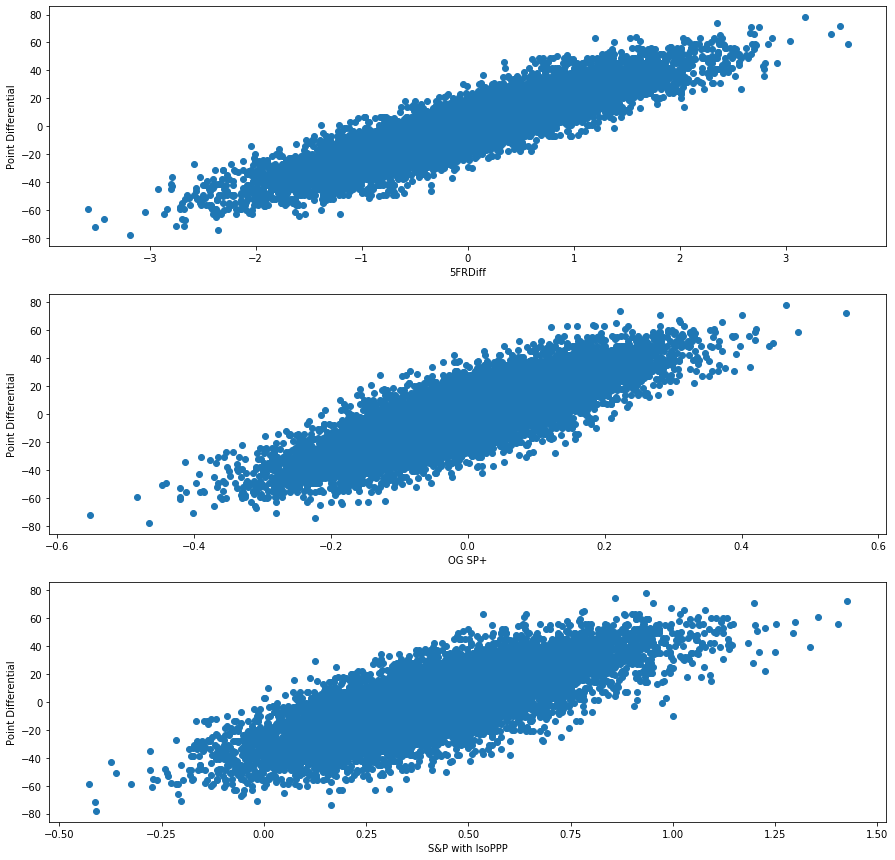

In [47]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [48]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [49]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.848400,0.939239,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.848400,0.939239,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.288888,0.319820,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.288888,0.319820,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.486696,0.538808,0.499553


In [50]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [51]:
# outliers

In [52]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.848400,0.939239,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.848400,0.939239,1.907384
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.288888,0.319820,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.486696,0.538808,0.499553
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0.00,0,-0.087917,6.578618,-0.26167,-0.059391,5.268829,0.486696,0.538808,0.499553


In [53]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [54]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 21.90149x + 0.01731
Mean Pred Score: -0.33466688304377623
Pred Std Dev: 19.848853886030845
Mean Abs Error: 7.551956085133997
Mdn Abs Error: 6.07982658511416
R-squared: 0.8113856107274209



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.776041,0.589591,0.505196,0.810523,0.593042,0.609603,0.982469,0.538988,0.774828,-0.477123,-0.462254,0.725723,0.758868,0.221172,0.569820,0.893733,0.900778,0.900778
OffSRDiff,0.776041,1.000000,0.485974,0.301521,0.709020,0.408603,0.454759,0.774683,0.755554,0.717378,-0.318932,-0.208078,0.646572,0.763064,-0.060229,0.570541,0.865113,0.845813,0.845813
OffERDiff,0.589591,0.485974,1.000000,0.175379,0.524843,0.306402,0.343809,0.583079,0.353993,0.807997,-0.218943,-0.118770,0.771981,0.632545,0.569952,0.219037,0.498667,0.529451,0.529451
FPDiff,0.505196,0.301521,0.175379,1.000000,0.599073,0.120393,0.135360,0.474739,0.090487,0.233635,-0.321871,-0.383245,0.235172,0.244862,0.017212,0.294969,0.590618,0.595374,0.595374
OppRateDiff,0.810523,0.709020,0.524843,0.599073,1.000000,0.235399,0.247991,0.808489,0.323331,0.676449,-0.348182,-0.312842,0.605455,0.753357,0.135909,0.540785,0.805421,0.807754,0.807754
OppEffDiff,0.593042,0.408603,0.306402,0.120393,0.235399,1.000000,0.729255,0.592432,0.519034,0.438136,-0.290691,-0.327658,0.409335,0.372183,0.162585,0.331134,0.507363,0.515467,0.515467
OppPPDDiff,0.609603,0.454759,0.343809,0.135360,0.247991,0.729255,1.000000,0.619266,0.560187,0.487040,-0.316282,-0.316505,0.462806,0.394710,0.179444,0.358493,0.574912,0.583641,0.583641
PPDDiff,0.982469,0.774683,0.583079,0.474739,0.808489,0.592432,0.619266,1.000000,0.536036,0.768775,-0.469538,-0.456675,0.719902,0.740832,0.214394,0.574140,0.886455,0.892906,0.892906
OppSRDiff,0.538988,0.755554,0.353993,0.090487,0.323331,0.519034,0.560187,0.536036,1.000000,0.545983,-0.248334,-0.131087,0.495268,0.475998,-0.028926,0.387735,0.636432,0.622764,0.622764
YPPDiff,0.774828,0.717378,0.807997,0.233635,0.676449,0.438136,0.487040,0.768775,0.545983,1.000000,-0.327712,-0.192556,0.922168,0.806882,0.523936,0.461717,0.705058,0.728090,0.728090


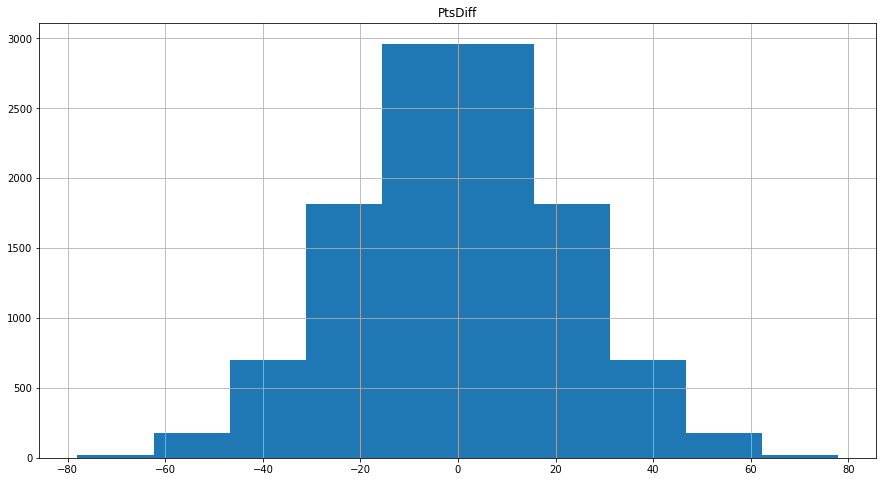

In [55]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

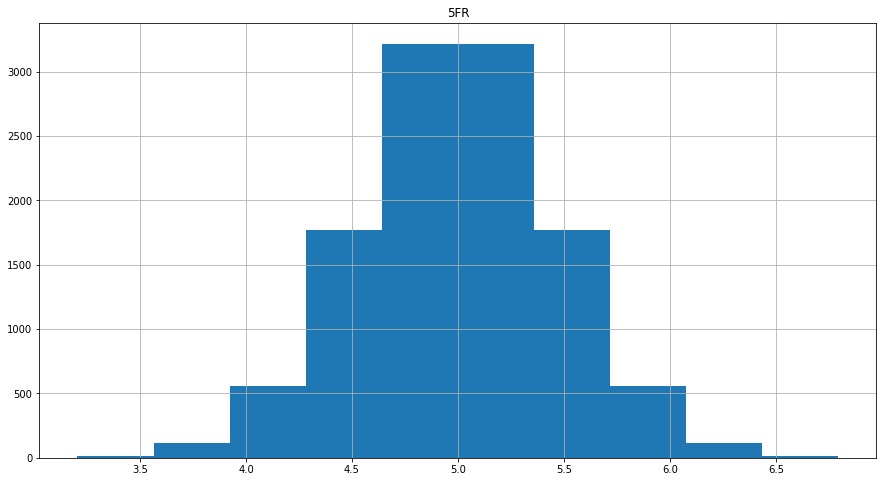

In [56]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

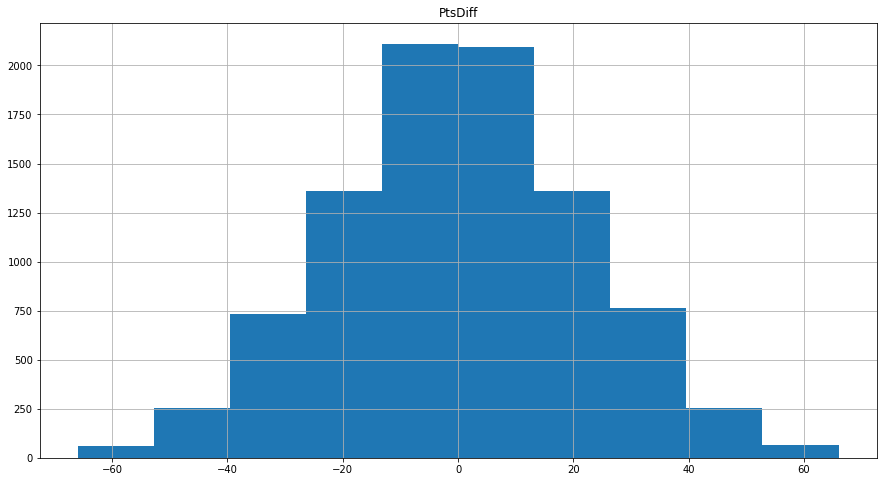

In [57]:
train_data.hist(column='PtsDiff', figsize=(15,8));

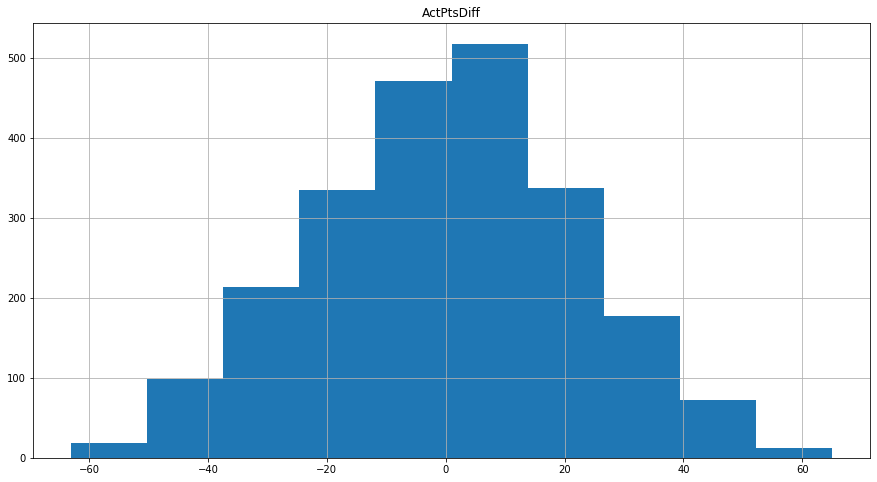

In [58]:
test.hist(column='ActPtsDiff', figsize=(15,8));

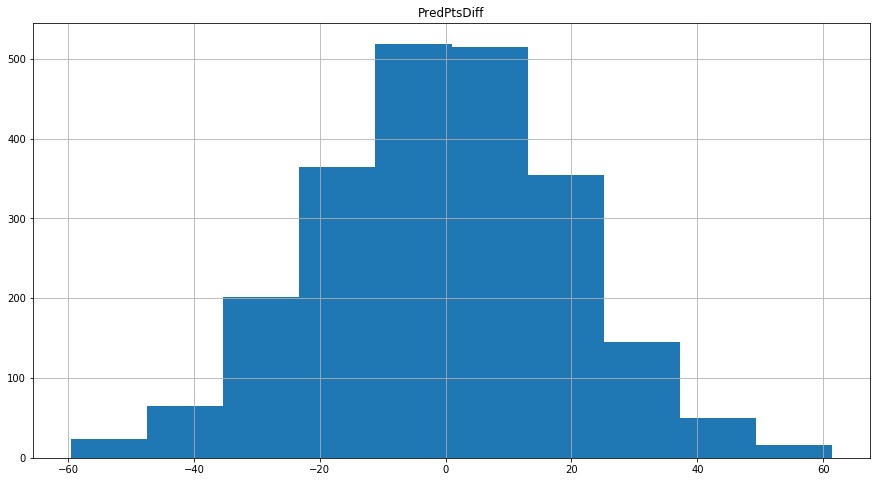

In [59]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [60]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [61]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.487269681097482)
Z score: -0.2092112129948324
Win Prob for Virginia Tech: 41.71%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [62]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -16.17010253332563)
Z score: -0.7978010086227929
Win Prob for Georgia Tech: 21.25%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [63]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -7.0 (exact value: -6.5562635808434875)
Z score: -0.31344866225139195
Win Prob for Georgia Tech: 37.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [64]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.786151112619553)
Z score: 0.3083713563920694
Win Prob for Mississippi State: 62.11%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [65]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -8.16607778822221)
Z score: -0.3945522975858065
Win Prob for Texas A&M: 34.66%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [66]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.934603,13,12.0,1.0
2,Clemson,0.932610,13,12.0,1.0
3,Alabama,0.922237,12,11.0,1.0
4,LSU,0.901997,13,12.0,1.0
5,Wisconsin,0.836628,13,11.0,2.0
6,Oregon,0.825399,13,11.0,2.0
7,Utah,0.814262,13,11.0,2.0
8,Appalachian State,0.805816,13,10.0,3.0
9,Notre Dame,0.805446,12,10.0,2.0
10,Oklahoma,0.792589,13,10.0,3.0


In [67]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.275660,1.724340
21,Clemson,10.540636,2.459364
53,LSU,10.292186,2.707814
2,Alabama,9.349928,2.650072
128,Wisconsin,9.120574,3.879426
115,Utah,9.017089,3.982911
3,Appalachian State,8.915737,4.084263
82,Oregon,8.756689,4.243311
30,Florida Atlantic,8.706263,4.293737
78,Oklahoma,8.662805,4.337195


In [68]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    if (~(teams[teams.school == team1].conference.isin(p5).all())):
        team1_avg_ffr *= 0.85 # arbitrary
    if (~(teams[teams.school == team2].conference.isin(p5).all())):
        team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.038009714628001234, -35.551781349323754]

In [69]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,12.896433,0.747484,True,Clemson,Clemson
0,Penn State,Memphis,7.0,9.926312,0.697406,True,Penn State,Penn State
0,LSU,Oklahoma,11.0,8.264005,0.667568,False,LSU,Oklahoma
0,Florida,Virginia,14.0,7.859487,0.660134,False,Florida,Virginia
0,Wisconsin,Oregon,2.5,-3.097661,0.444645,False,Oregon,Oregon
0,Georgia,Baylor,7.5,-5.442757,0.398455,False,Baylor,Baylor


In [70]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 6.0 (exact value: 6.382185664553035)
Z score: 0.3384000197776645
Win Prob for Virginia: 63.25%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [71]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 12.285845049047095)
Z score: 0.6358307640610368
Win Prob for North Carolina: 73.76%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [72]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 15.0 (exact value: 14.806276096695136)
Z score: 0.7628119520993981
Win Prob for Pittsburgh: 77.72%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [73]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -8.00148499268195)
Z score: -0.38625999030774766
Win Prob for Auburn: 34.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [74]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 27.0 (exact value: 26.642820160789697)
Z score: 1.3591458327384631
Win Prob for Georgia: 91.29%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [75]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 20.0 (exact value: 20.034802957460435)
Z score: 1.0262290184341456
Win Prob for Clemson: 84.76%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.590970602236132)
Z score: 0.2481572746498202
Win Prob for Georgia Tech: 59.80%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -13.0 (exact value: -13.28668308242205)
Z score: -0.6525321952464771
Win Prob for The Citadel: 25.70%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 26.0 (exact value: 26.370876263910464)
Z score: 1.3454450972481071
Win Prob for Temple: 91.08%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 12.285845049047095)
Z score: 0.6358307640610

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,15.239182
5900,401112441,2019,Georgia Tech,South Florida,4.0,59.799364
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,74.297104
6107,401112469,2019,Georgia Tech,Temple,-22.0,8.924077
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,26.244337
6198,401112480,2019,Georgia Tech,Duke,-18.0,26.686624
6251,401112488,2019,Georgia Tech,Miami,7.0,21.249299
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,22.278778
6418,401112504,2019,Georgia Tech,Virginia,-5.0,19.088632
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.123429


In [76]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)